# Autoencoder (AE) Labeling using PyTorch

In [1]:
import turbo as tb
import preprocessing as pr
import labeling as lb
import classification as cl
import rul_dataframe as rd
import plots as pl

import copy
import numpy as np
import pandas as pd

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
tr, te, rl = tb.getTFDataset(set = 4)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])

In [3]:
pre = pr.Preprocessing()
clf = cl.Classification()
lbl = lb.Labeling()

In [4]:
rul_df = copy.deepcopy(tr_df)
rul_df_test = copy.deepcopy(te_df)

In [5]:
clf.fit_kmeans(rul_df = rul_df)
pre.one_hot_encode(rul_df = rul_df)
pre.c_drop_zero_variance(rul_df = rul_df , c_cols = rul_df.categ_cols, eps = 0.0001)
pre.c_scale(rul_df = rul_df, c_cols = rul_df.categ_cols)
pre.exponential_smooth(rul_df = rul_df, alpha = 0.4)

In [6]:
Xtr = rul_df.df[[rul_df.id_col, rul_df.time_col] + rul_df.data_cols].copy()
for i, d in Xtr.groupby(rul_df.id_col):
    quarter = int(d.shape[0] / 4) + 1
    Xtr = Xtr.drop(range(d.index[0] + quarter, d.index[-1] + 1))

train_target = torch.tensor(Xtr[rul_df.time_col].values.astype(np.float32))
train = torch.tensor(Xtr[rul_df.data_cols].values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 64, shuffle = True)

test_target = torch.tensor(rul_df.df[rul_df.time_col].values.astype(np.float32))
test = torch.tensor(rul_df.df[rul_df.data_cols].values.astype(np.float32)) 
test_tensor = TensorDataset(test, test_target) 
test_loader = DataLoader(dataset = test_tensor, batch_size = 64)

## Basic AE

In [1]:
class BaseAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features = kwargs["input_shape"], out_features = 12
        )
        self.encoder_output_layer = nn.Linear(
            in_features = 12, out_features = 8
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features = 8, out_features = 12
        )
        self.decoder_output_layer = nn.Linear(
            in_features = 12, out_features = kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

NameError: name 'nn' is not defined

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseAE(input_shape = len(rul_df.data_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

In [9]:
epochs = 15
model.train()

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/15, loss = 0.420991
epoch : 2/15, loss = 0.404812
epoch : 3/15, loss = 0.402589
epoch : 4/15, loss = 0.401083
epoch : 5/15, loss = 0.401125
epoch : 6/15, loss = 0.400567
epoch : 7/15, loss = 0.400880
epoch : 8/15, loss = 0.400807
epoch : 9/15, loss = 0.400594
epoch : 10/15, loss = 0.400469
epoch : 11/15, loss = 0.400135
epoch : 12/15, loss = 0.400000
epoch : 13/15, loss = 0.399956
epoch : 14/15, loss = 0.400138
epoch : 15/15, loss = 0.399992


In [10]:
model.eval()
error = []
with torch.no_grad():
    for batch_features, _ in test_loader:
        outputs = model(batch_features)
        for i in range(batch_features.size()[0]):
            error.append(criterion(outputs[i], batch_features[i]).item())            

In [27]:
rul_df.df['bae'] = error

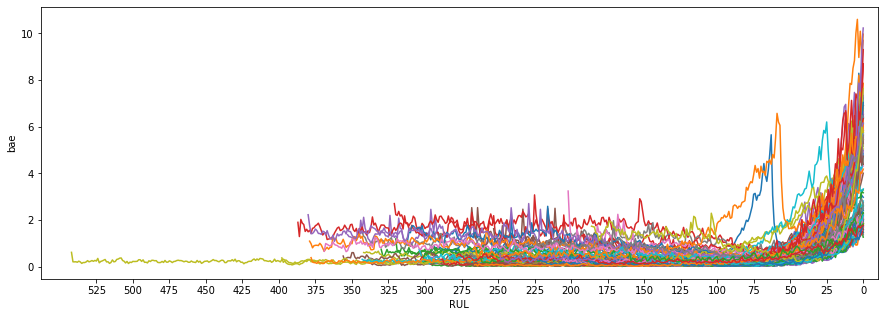

In [28]:
plt = pl.Plots(rul_df = rul_df)
plt.reversetimeplot_column('bae', mod = 2)

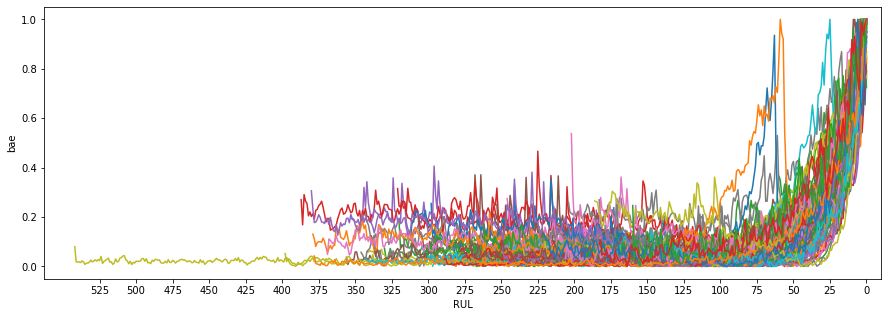

In [30]:
scale_col = lambda x: (x - x.min()) / (x.max() - x.min())
rul_df.df['bae'] = rul_df.df[[rul_df.id_col, 'bae']].groupby(rul_df.id_col).transform(scale_col)
plt.reversetimeplot_column('bae',mod=2)

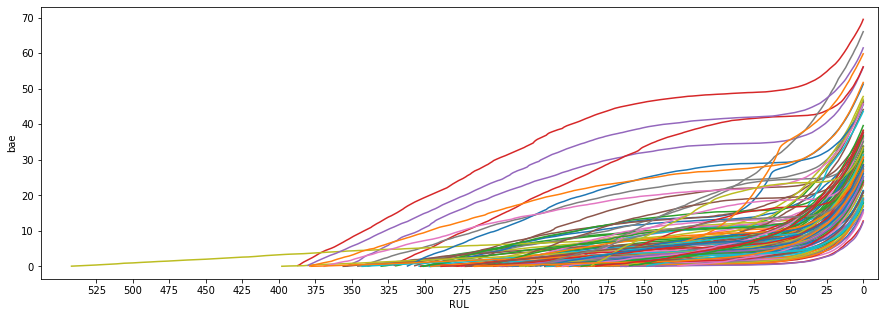

In [31]:
rul_df.df['bae'] = rul_df.df[[rul_df.id_col, 'bae']].groupby(rul_df.id_col).cumsum()
plt.reversetimeplot_column('bae', mod=2)

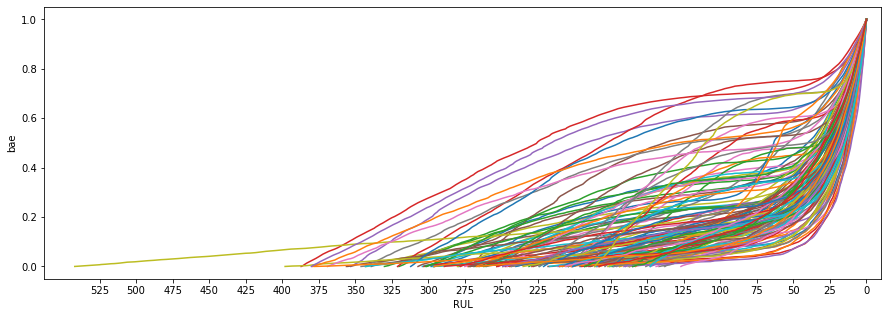

In [32]:
rul_df.df['bae'] = rul_df.df[[rul_df.id_col, 'bae']].groupby(rul_df.id_col).transform(scale_col)
plt.reversetimeplot_column('bae', mod=2)

## Variational AE

In [39]:
class VarBaseAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_output_layer_mu = nn.Linear(
            in_features = kwargs["input_shape"], out_features = 8
        )
        self.encoder_output_layer_var = nn.Linear(
            in_features = kwargs["input_shape"], out_features = 8
        )
        self.decoder_output_layer = nn.Linear(
            in_features = 8, out_features = kwargs["input_shape"]
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, features):
        mu = self.encoder_output_layer_mu(features)
        var = self.encoder_output_layer_var(features)

        code = self.reparameterize(mu = mu, logvar = var)
        
        reconstructed = self.decoder_output_layer(code)
        reconstructed = torch.relu(reconstructed)
        return reconstructed

In [40]:
model2 = VarBaseAE(input_shape = len(rul_df.data_cols)).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

In [41]:
epochs = 15
model2.train()

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs = model2(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/15, loss = 0.548659
epoch : 2/15, loss = 0.427331
epoch : 3/15, loss = 0.415969
epoch : 4/15, loss = 0.408638
epoch : 5/15, loss = 0.403282
epoch : 6/15, loss = 0.400327
epoch : 7/15, loss = 0.398701
epoch : 8/15, loss = 0.397490
epoch : 9/15, loss = 0.396403
epoch : 10/15, loss = 0.395370
epoch : 11/15, loss = 0.394209
epoch : 12/15, loss = 0.393314
epoch : 13/15, loss = 0.392696
epoch : 14/15, loss = 0.392041
epoch : 15/15, loss = 0.391319


In [42]:
model2.eval()
error2 = []
with torch.no_grad():
    for batch_features, _ in test_loader:
        outputs = model2(batch_features)
        for i in range(batch_features.size()[0]):
            error2.append(criterion(outputs[i], batch_features[i]).item())

In [43]:
rul_df.df['vbae'] = error2

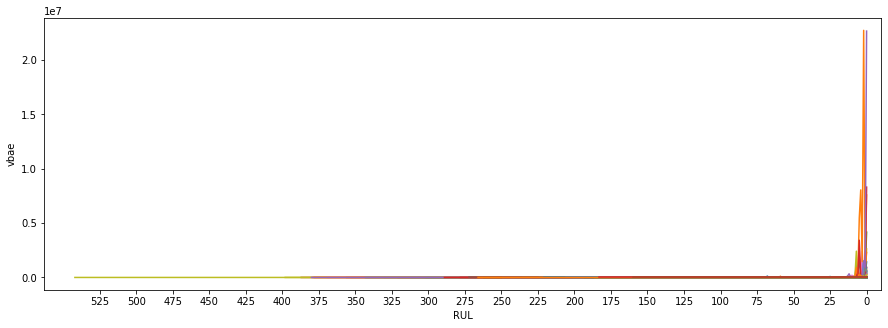

In [44]:
plt.reversetimeplot_column('vbae', mod=2)

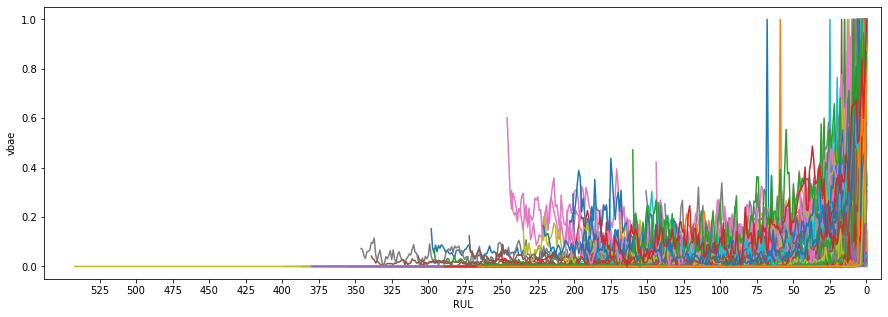

In [45]:
rul_df.df['vbae'] = rul_df.df[[rul_df.id_col, 'vbae']].groupby(rul_df.id_col).transform(scale_col)
plt.reversetimeplot_column('vbae',mod=2)

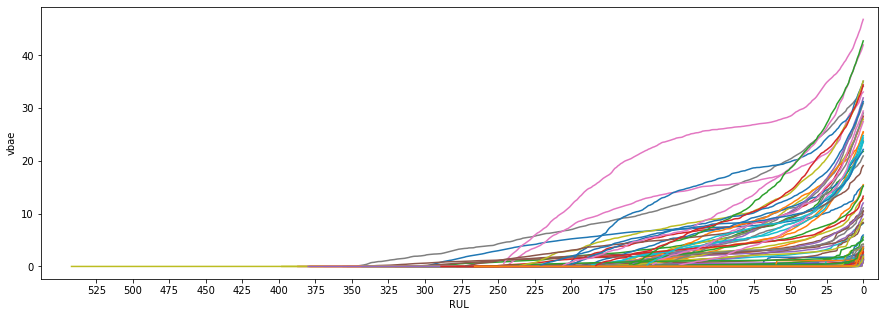

In [46]:
rul_df.df['vbae'] = rul_df.df[[rul_df.id_col, 'vbae']].groupby(rul_df.id_col).cumsum()
plt.reversetimeplot_column('vbae', mod=2)

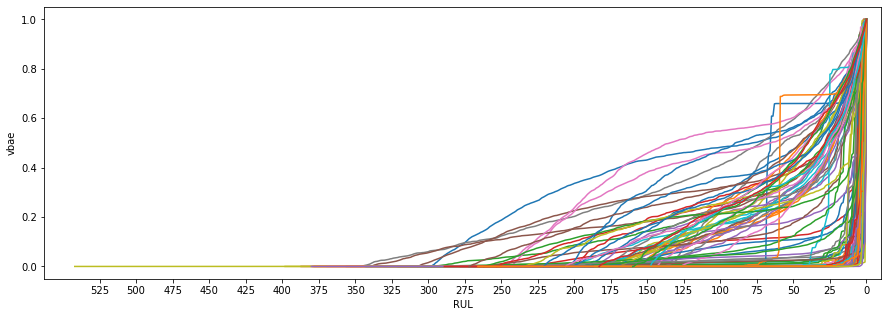

In [47]:
rul_df.df['vbae'] = rul_df.df[[rul_df.id_col, 'vbae']].groupby(rul_df.id_col).transform(scale_col)
plt.reversetimeplot_column('vbae', mod=2)

## RNN/LSTM AE

## Veriational RNN/LSTM AE